## Why PID Control?

In any **standard feedback control system**, three realities always appear:

1. **We have a goal** – the reference input *r(t)* tells us where we want to be.  
2. **We face disruptions** – disturbances act directly on the plant, pushing it off course.  
3. **We see through an imperfect lens** – sensors add noise, so our measurements are never exact.  

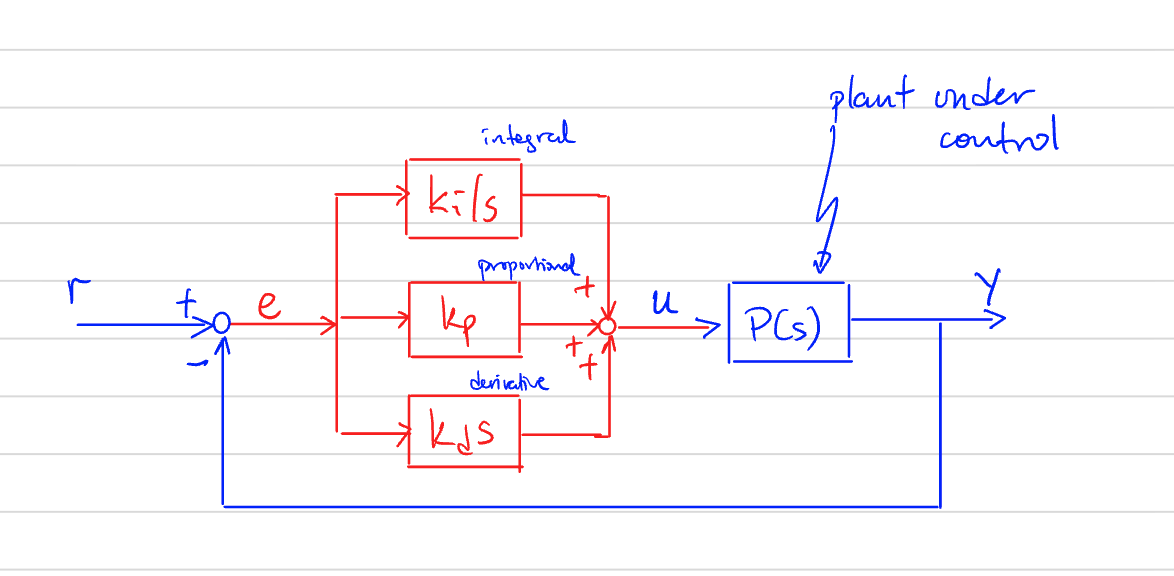

### 1. $r$ sets the target (reference input)  
- The signal $r(t)$ represents what we want the system to do.  
- It could be a constant (e.g., “hold the temperature at 25°C”), or a time-varying trajectory (e.g., “make the drone follow this flight path”).  
- This is the *command* to the system, and the whole point of the controller is to make the output $y(t)$ follow this reference.  



### 2. $y$ is the achieved result (plant output)  
- The signal $y(t)$ is what the plant actually produces in response to the control input $u(t)$.  
- In real systems, $y(t)$ may lag behind $r(t)$, overshoot it, or never reach it due to limitations, disturbances, or modeling errors.  
- This is the only “truth” we can observe about the system’s performance — if $y(t)$ doesn’t match $r(t)$, we know correction is needed.  


### 3. $e = r - y$ tells us the gap (error signal)  
- The error signal $e(t)$ quantifies how far the system is from its target:  
  $$
  e(t) = r(t) - y(t)
  $$  
- A positive error means the output is below the desired value, while a negative error means the output has overshot.  
- The PID controller takes this error as its *input*, continuously computing corrections that drive the error toward zero.  
- In other words: **no error → no control action.**  


In the feedback loop:  
- $r$ is the **goal**,  
- $y$ is the **reality**,  
- $e = r - y$ is the **gap** the controller works to close.  


The **PID controller** gives us a powerful, yet simple, way to respond:

- **Proportional (P):** Pushes against error immediately, keeping the system from drifting away.  
- **Integral (I):** Eliminates steady-state error, guaranteeing that the output will eventually track the reference exactly, even under constant disturbances.  
- **Derivative (D):** Anticipates error trends, adding stability and damping so the system avoids overshoot and oscillations.  

**In short, PID empowers us to:**

- 🎯 **Track** the reference accurately,  
- 🛡️ **Reject** the influence of disturbances, and  
- ⚖️ **Stay robust** despite sensor noise and modeling uncertainty.  

This is why PID is the most widely used controller in engineering practice:  
**it balances simplicity, intuition, and effectiveness to tame real-world systems.**


The error signal is defined as  

$$
e(t) = r(t) - y(t)
$$

The PID control law is  

$$
u(t) = K_p e(t)
      + K_i \int_{0}^{t} e(\tau)\, d\tau
      + K_d \frac{de(t)}{dt}
$$

- **Proportional term**: $K_p e(t)$  
- **Integral term**: $K_i \int_{0}^{t} e(\tau)\, d\tau$  
- **Derivative term**: $K_d \tfrac{de(t)}{dt}$  

The corresponding transfer function from error $e$ to control input $u$ is  

$$
C(s) = K_p + \frac{K_i}{s} + K_d s
$$

In [ ]:
# Install required packages
!pip install numpy matplotlib scipy

# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import math

In [13]:
# Plant: underdamped second-order system
wn = 2.0  # natural frequency
zeta = 0.1  # damping ratio
num_p = [wn**2]
den_p = [1, 2*zeta*wn, wn**2]
Gp = signal.TransferFunction(num_p, den_p)

# Time vector
t = np.linspace(0, 8, 800)

def multiply_tf(tf1, tf2):
    """Multiply two transfer functions manually"""
    # (n1/d1) * (n2/d2) = (n1*n2)/(d1*d2)
    num = np.polymul(tf1.num, tf2.num)
    den = np.polymul(tf1.den, tf2.den)
    return signal.TransferFunction(num, den)

def closed_loop_tf(Gc, Gp):
    """Calculate closed-loop transfer function T = GcGp/(1+GcGp)"""
    # First multiply Gc * Gp
    GcGp = multiply_tf(Gc, Gp)

    # T = GcGp / (1 + GcGp)
    # This means T = GcGp.num / (GcGp.den + GcGp.num)
    num_cl = GcGp.num
    den_cl = np.polyadd(GcGp.den, GcGp.num)

    return signal.TransferFunction(num_cl, den_cl)

print(f"Plant: {Gp}")

Plant: TransferFunctionContinuous(
array([4.]),
array([1. , 0.4, 4. ]),
dt: None
)


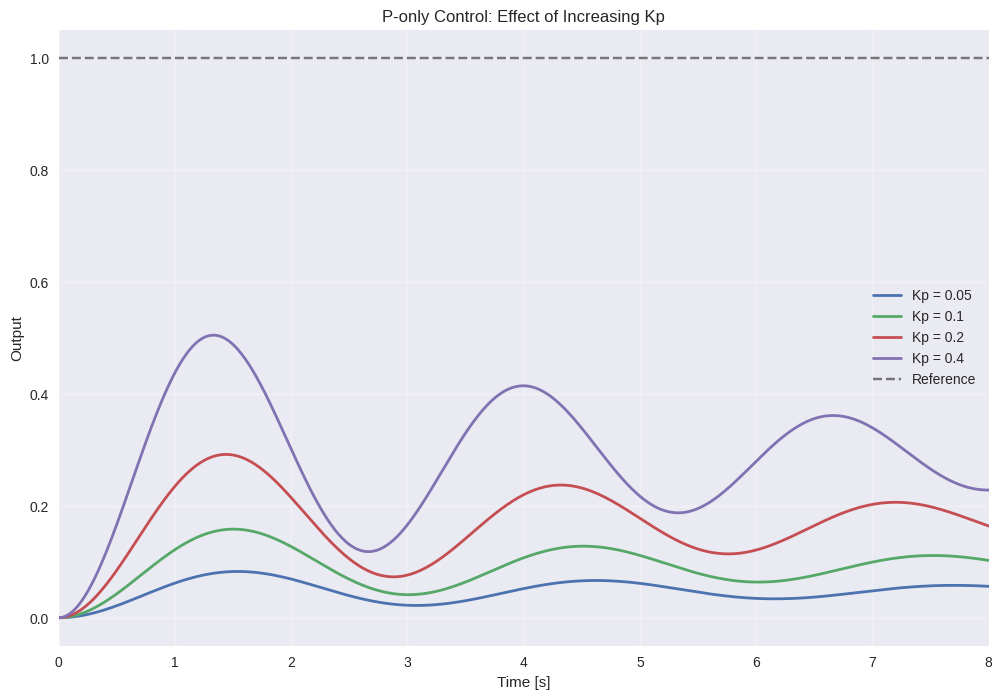

Steady-state values (should be 1.0 for perfect tracking):
Kp = 0.05: SS value = 0.056, SS error = 0.944
Kp = 0.1: SS value = 0.102, SS error = 0.898
Kp = 0.2: SS value = 0.164, SS error = 0.836
Kp = 0.4: SS value = 0.228, SS error = 0.772

🔍 Observations:
• Higher Kp → faster response but more overshoot
• Steady-state error remains (P-only cannot eliminate it for step inputs)
• Too high Kp → system becomes oscillatory/unstable


In [14]:
# Test different Kp values
Kp_values = [0.05, 0.10, 0.20, 0.40]
plt.figure(figsize=(12, 8))

for i, Kp in enumerate(Kp_values):
    # P-only controller
    Gc = signal.TransferFunction([Kp], [1])

    # Closed-loop transfer function T(s) = GcGp/(1+GcGp)
    T_cl = closed_loop_tf(Gc, Gp)

    # Step response
    t_step, y_step = signal.step(T_cl, T=t)

    plt.plot(t_step, y_step, label=f'Kp = {Kp}', linewidth=2)

plt.axhline(y=1, color='k', linestyle='--', alpha=0.5, label='Reference')
plt.xlabel('Time [s]')
plt.ylabel('Output')
plt.title('P-only Control: Effect of Increasing Kp')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, 8)
plt.show()

# Show steady-state error for each case
print("Steady-state values (should be 1.0 for perfect tracking):")
for Kp in Kp_values:
    Gc = signal.TransferFunction([Kp], [1])
    T_cl = closed_loop_tf(Gc, Gp)
    _, y_step = signal.step(T_cl, T=t)
    ss_value = y_step[-1]
    ss_error = 1.0 - ss_value
    print(f"Kp = {Kp}: SS value = {ss_value:.3f}, SS error = {ss_error:.3f}")

print("\n🔍 Observations:")
print("• Higher Kp → faster response but more overshoot")
print("• Steady-state error remains (P-only cannot eliminate it for step inputs)")
print("• Too high Kp → system becomes oscillatory/unstable")